# Interpretability of pain behavior recognition

## First we need dataframes for every subject

In [2]:
import sys
sys.path.append('../')

%matplotlib inline

# DEFINE GRAPH
import pandas as pd
import numpy as np
import utils

from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = '../data/jpg_128_128_16fps_OF_magnitude_cv2/'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [5]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [6]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                 of_path=args.of_path,
                 clip_list_file='videos_overview_missingremoved.csv',
                 data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                 image_size=(args.input_height, args.input_width),
                 seq_length=args.seq_length,
                 seq_stride=args.seq_stride,
                 batch_size=args.batch_size,
                 color=COLOR,
                 nb_labels=args.nb_labels,
                 aug_flip=args.aug_flip,
                 aug_crop=args.aug_crop,
                 aug_light=args.aug_light)

In [7]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


In [8]:
subject_dfs = utils.read_or_create_subject_rgb_and_OF_dfs(dh, args, subject_ids, subject_dfs)

## Now that we have frames from all subjects, we can import gradcam functionality

In [9]:
# Choose a model to work on
two_stream = True

if two_stream: # This model got 88.09 % F1-score
    best_model_path = '../models/BEST_MODEL_2stream_5d_add_adadelta_LSTMunits_32_CONVfilters_16_add_v4_t3_4hl_128jpg2fps_seq10_bs8_MAG_adadelta_noaug_run1_rerun_gc.h5'
else:
    best_model_path = '../models/1stream_summer_2018/no_aug/BEST_MODEL_convolutional_LSTM_adadelta_LSTMunits_32_CONVfilters_None_jpg128_2fps_val0_t4_seq10ss10_4hl_32ubs16_no_aug_run4.h5'
import keras
m = keras.models.load_model(best_model_path)

In [10]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
flows = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])

if two_stream:
    clstm_model = utils.TwoStreamCLSTMNetwork(images, flows, from_scratch=0, path=best_model_path)
else:
    clstm_model = utils.CLSTMNetwork(images, from_scratch=0, path=best_model_path)

sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(clstm_model.preds)), axis=1)
    
y_c = tf.reduce_sum(tf.multiply(clstm_model.dense, labels), axis=1)

print('model preds: ', clstm_model.preds)
print('cost: ', cost)
print('y_c: ', y_c)


    
if two_stream:
    target_conv_layer = clstm_model.clstm4_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.clstm1_rgb # Choose which CLSTM-layer to study
    # target_conv_layer = clstm_model.merge # Choose which CLSTM-layer to study
else:
    target_conv_layer = clstm_model.clstm4 # Choose which CLSTM-layer to study
    
print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, [images, flows])[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_1_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("conv_lst_m2d_4_2/transpose_1:0", shape=(1, ?, 16, 16, 32), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_4_2/transpose_grad/transpose:0", shape=(1, ?, 16, 16, 32), dtype=float32)


In [11]:
def run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True):
    with sess.as_default():

        # 2-stream
        if two_stream:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       flows: batch_flow,
                                       K.learning_phase(): 0})

            print(prob)

            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                                     flows: batch_flow,
                                     labels: batch_label,
                                     K.learning_phase(): 0})

            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                             (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                             (1, 10, 16, 16, 32))
            
        else:
            prob = sess.run(clstm_model.preds,
                            feed_dict={images: batch_img,
                                       K.learning_phase(): 0})

            print(prob)
            gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value =                 sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                          feed_dict={images: batch_img,
                          labels: batch_label,
                          K.learning_phase(): 0})
            target_conv_layer_value = np.reshape(target_conv_layer_value,
                                         (1, 10, 16, 16, 32))
            target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                         (1, 10, 16, 16, 32))


        utils.visualize_overlays(batch_img, target_conv_layer_value,
                           target_conv_layer_grad_value, batch_flow)


# Two-stream predictions for subject t3

Chose subject  3
Start index in subject dataframe:  3770
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_1c/frame_000123.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_1c/frame_000124.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_1c/frame_000125.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_1c/frame_000126.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_1c/frame_000127.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_1c/frame_000128.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_1c/frame_000129.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_1c/frame_000130.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_1c/frame_000131.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_1c/frame_000132.jpg     0
[[[0.7544185  0.23629732]
  [0.94362074 0.07861597]
  [0.98250824 0.02030852]
  [0.9892273  0.00930846]
  [0.99093187 0.00449525]
  [0.9898958  0.00351625]
  [0.9862576  0.00274245]
  [0.975368   0.00315142]
  [0.9726576  0.00447685]
  [0.9786098  0.00662156]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


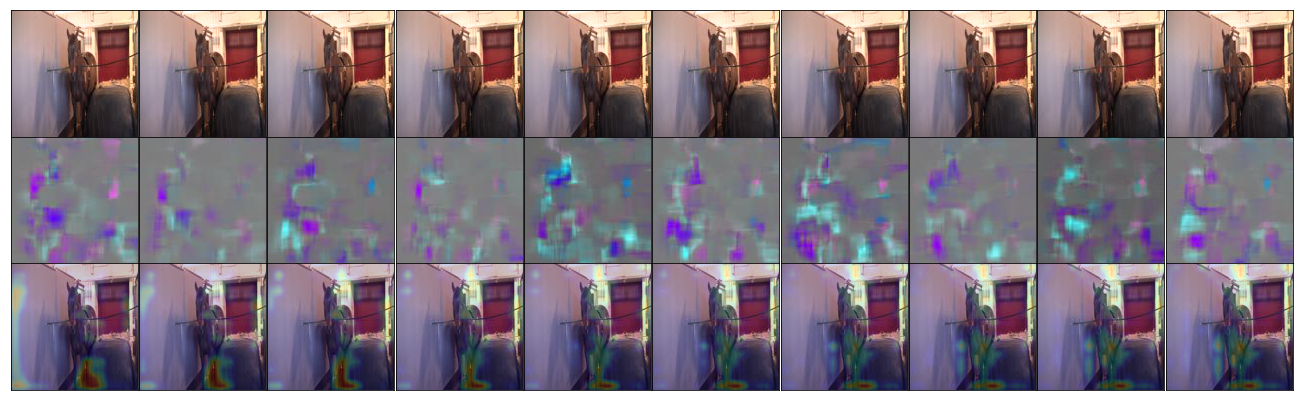

In [12]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  13030
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_4a/frame_000355.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_4a/frame_000356.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_4a/frame_000357.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_4a/frame_000358.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_4a/frame_000359.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_4a/frame_000360.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_4a/frame_000361.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_4a/frame_000362.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_4a/frame_000363.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_4a/frame_000364.jpg     1
[[[0.49933153 0.44915494]
  [0.4554527  0.54471946]
  [0.27537426 0.6248101 ]
  [0.16568816 0.7606993 ]
  [0.09653442 0.8386072 ]
  [0.07991298 0.8427375 ]
  [0.0643955  0.74188656]
  [0.06795888 0.6293124 ]
  [0.0932588  0.5203579 ]
  [0.11854706 0.3688063 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


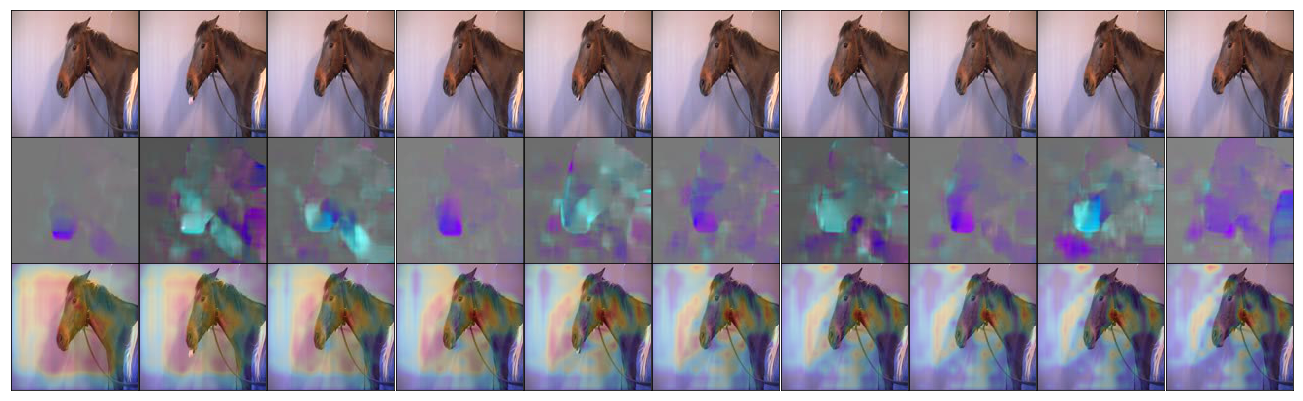

In [13]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  4496
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_1c/frame_000849.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_1c/frame_000850.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_1c/frame_000851.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_1c/frame_000852.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_1c/frame_000853.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_1c/frame_000854.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_1c/frame_000855.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_1c/frame_000856.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_1c/frame_000857.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_1c/frame_000858.jpg     0
[[[0.7339122  0.20294611]
  [0.92656326 0.07188794]
  [0.9636772  0.02883972]
  [0.974842   0.01894862]
  [0.97059834 0.02588824]
  [0.9646582  0.03606201]
  [0.954286   0.03603284]
  [0.9523532  0.02514101]
  [0.969724   0.02059275]
  [0.9676284  0.0176472 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


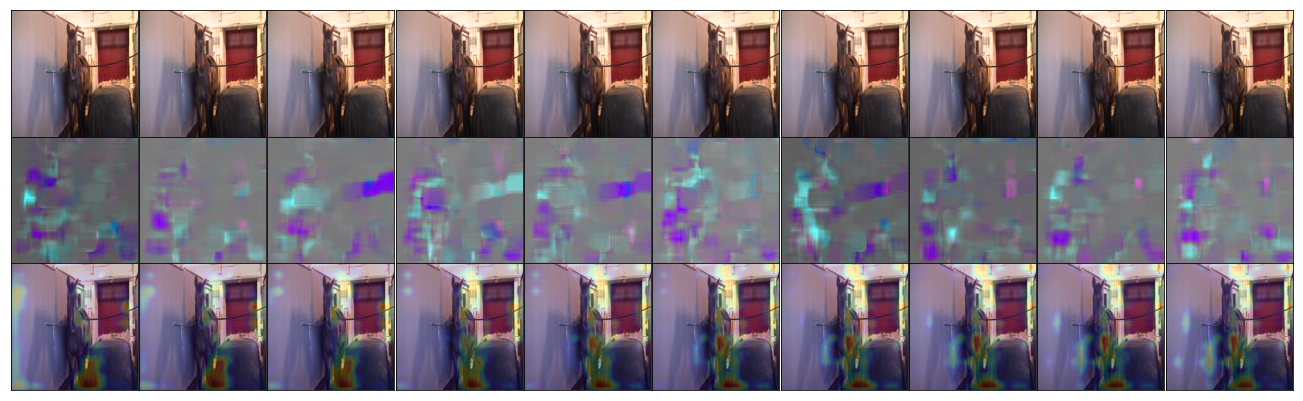

In [14]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  4007
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_1c/frame_000360.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_1c/frame_000361.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_1c/frame_000362.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_1c/frame_000363.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_1c/frame_000364.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_1c/frame_000365.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_1c/frame_000366.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_1c/frame_000367.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_1c/frame_000368.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_1c/frame_000369.jpg     0
[[[0.7210908  0.3704063 ]
  [0.8867978  0.34813687]
  [0.8972416  0.17280437]
  [0.9042696  0.08475586]
  [0.89601636 0.05651334]
  [0.93490165 0.04452587]
  [0.94526386 0.03536866]
  [0.94028354 0.04135527]
  [0.94303143 0.05008636]
  [0.95807177 0.04853733]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


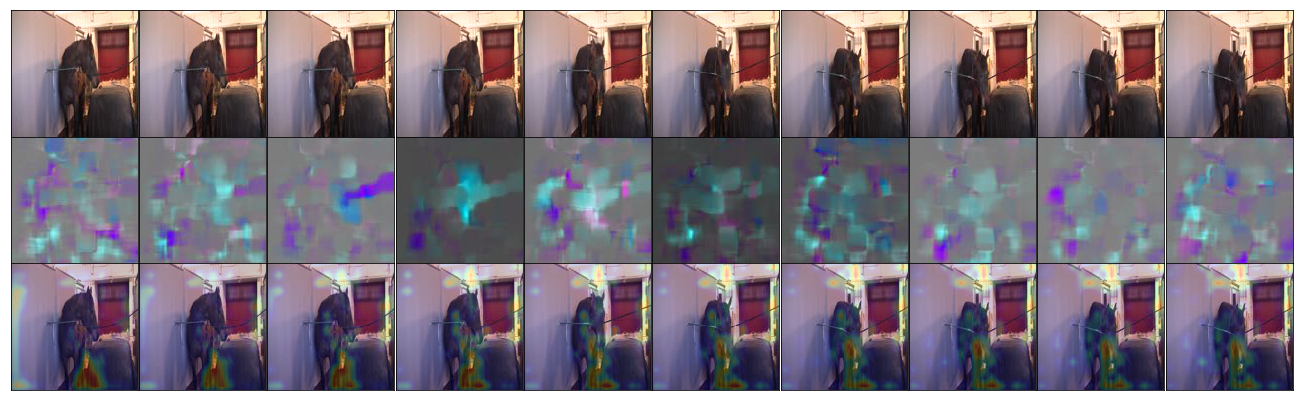

In [15]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  8864
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_2a/frame_001569.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_2a/frame_001570.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_2a/frame_001571.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_2a/frame_001572.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_2a/frame_001573.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_2a/frame_001574.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_2a/frame_001575.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_2a/frame_001576.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_2a/frame_001577.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_2a/frame_001578.jpg     0
[[[0.4793383  0.34569895]
  [0.40565762 0.2105879 ]
  [0.289549   0.10548891]
  [0.19209424 0.062154  ]
  [0.15976204 0.05470598]
  [0.16398112 0.0657725 ]
  [0.1689819  0.10872398]
  [0.16759016 0.1663263 ]
  [0.17835037 0.1661141 ]
  [0.13882159 0.14702074]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


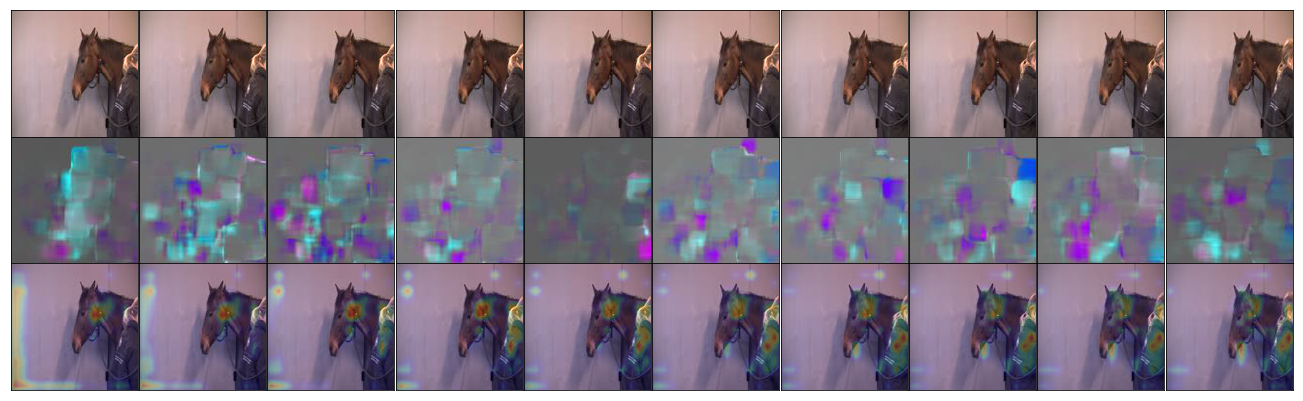

In [16]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  9142
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_2a/frame_001847.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_2a/frame_001848.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_2a/frame_001849.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_2a/frame_001850.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_2a/frame_001851.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_2a/frame_001852.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_2a/frame_001853.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_2a/frame_001854.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_2a/frame_001855.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_2a/frame_001856.jpg     0
[[[0.45101392 0.409161  ]
  [0.35908058 0.4008084 ]
  [0.30314827 0.3770406 ]
  [0.42357287 0.32999524]
  [0.5023163  0.33537957]
  [0.50549054 0.37653   ]
  [0.51334107 0.35859817]
  [0.57967246 0.43791378]
  [0.67152786 0.60642344]
  [0.7237508  0.593642  ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


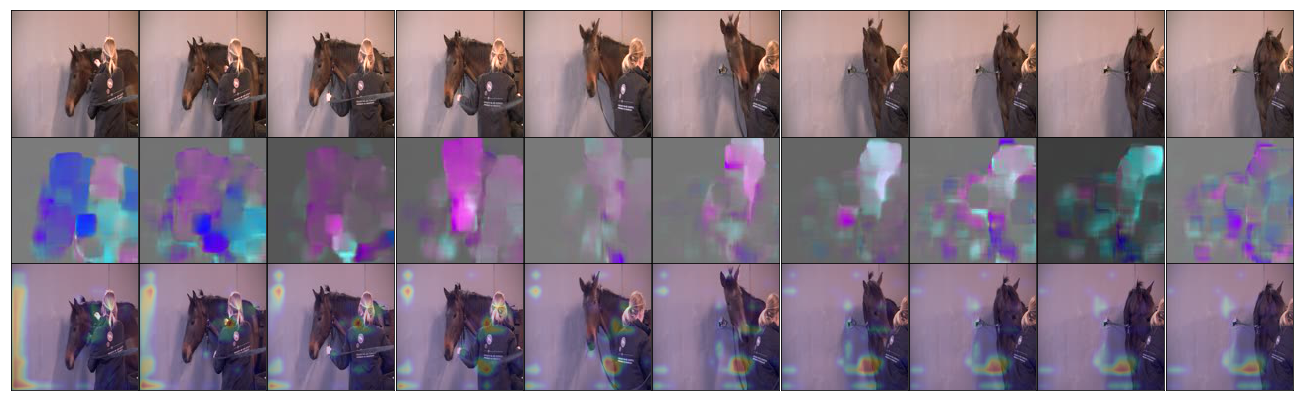

In [17]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  9556
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_2b/frame_000239.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_2b/frame_000240.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_2b/frame_000241.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_2b/frame_000242.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_2b/frame_000243.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_2b/frame_000244.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_2b/frame_000245.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_2b/frame_000246.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_2b/frame_000247.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_2b/frame_000248.jpg     0
[[[0.41756022 0.44759294]
  [0.2735443  0.43739203]
  [0.14178418 0.4612097 ]
  [0.10779081 0.51197034]
  [0.13624604 0.5392797 ]
  [0.11602221 0.60695696]
  [0.08197948 0.76258326]
  [0.06821591 0.8138286 ]
  [0.05962333 0.8288724 ]
  [0.05277251 0.8743248 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


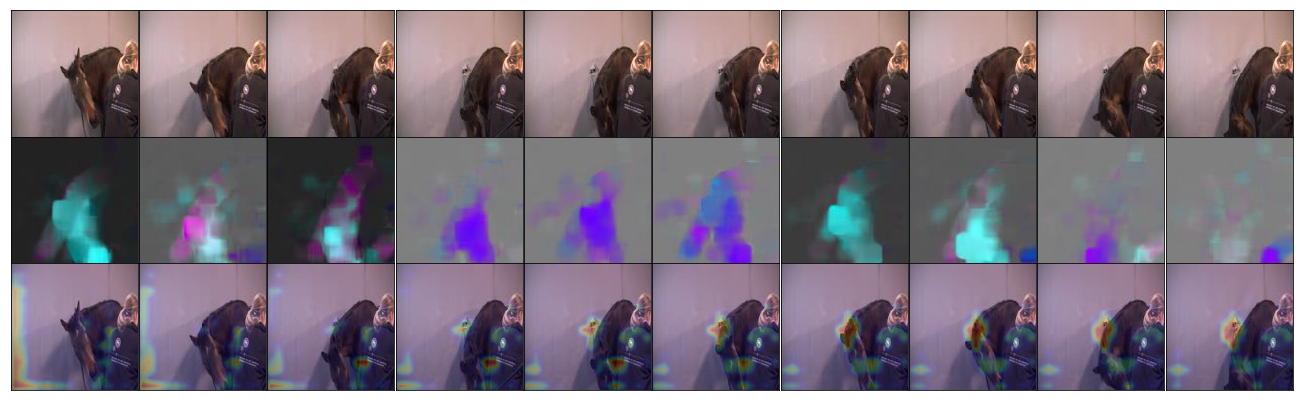

In [18]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  13442
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_4a/frame_000767.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_4a/frame_000768.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_4a/frame_000769.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_4a/frame_000770.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_4a/frame_000771.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_4a/frame_000772.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_4a/frame_000773.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_4a/frame_000774.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_4a/frame_000775.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_4a/frame_000776.jpg     1
[[[4.7070336e-01 5.0927842e-01]
  [1.7370470e-01 6.5996790e-01]
  [3.7303258e-02 8.9224261e-01]
  [1.2179146e-02 9.4511497e-01]
  [4.3596737e-03 9.6640921e-01]
  [1.5755864e-03 9.7423708e-01]
  [8.6695730e-04 9.7672278e-01]
  [1.3554198e-03 9.8530418e-01]
  [3.3311839e-0

/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


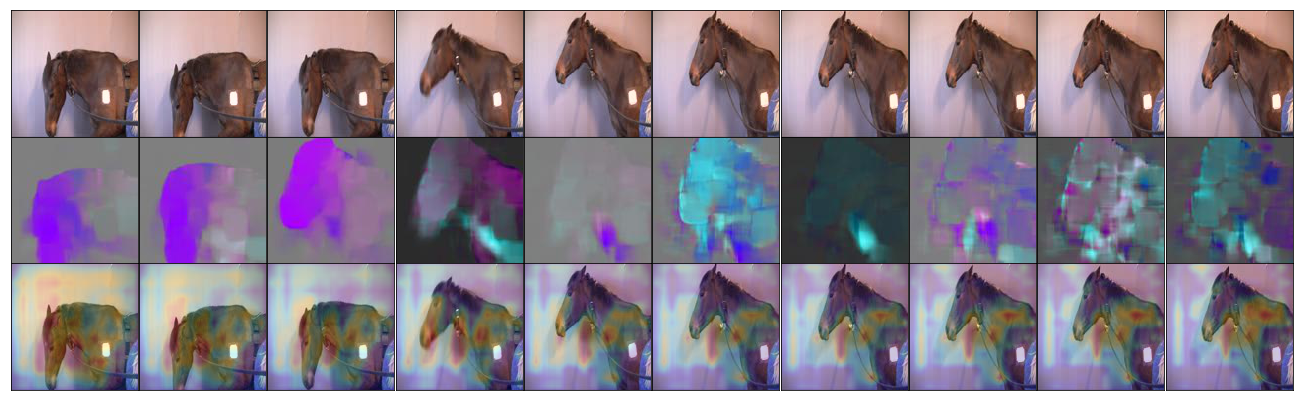

In [19]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  4560
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_1c/frame_000913.jpg     0
1  data/jpg_128_128_2fps/horse_4/4_1c/frame_000914.jpg     0
2  data/jpg_128_128_2fps/horse_4/4_1c/frame_000915.jpg     0
3  data/jpg_128_128_2fps/horse_4/4_1c/frame_000916.jpg     0
4  data/jpg_128_128_2fps/horse_4/4_1c/frame_000917.jpg     0
5  data/jpg_128_128_2fps/horse_4/4_1c/frame_000918.jpg     0
6  data/jpg_128_128_2fps/horse_4/4_1c/frame_000919.jpg     0
7  data/jpg_128_128_2fps/horse_4/4_1c/frame_000920.jpg     0
8  data/jpg_128_128_2fps/horse_4/4_1c/frame_000921.jpg     0
9  data/jpg_128_128_2fps/horse_4/4_1c/frame_000922.jpg     0
[[[0.76449597 0.23954765]
  [0.9452295  0.13287772]
  [0.98665595 0.03516908]
  [0.9929496  0.01161668]
  [0.99175537 0.00670291]
  [0.9929174  0.00584339]
  [0.99406284 0.00431549]
  [0.99593276 0.0049693 ]
  [0.99628747 0.00656939]
  [0.99569666 0.0042044 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


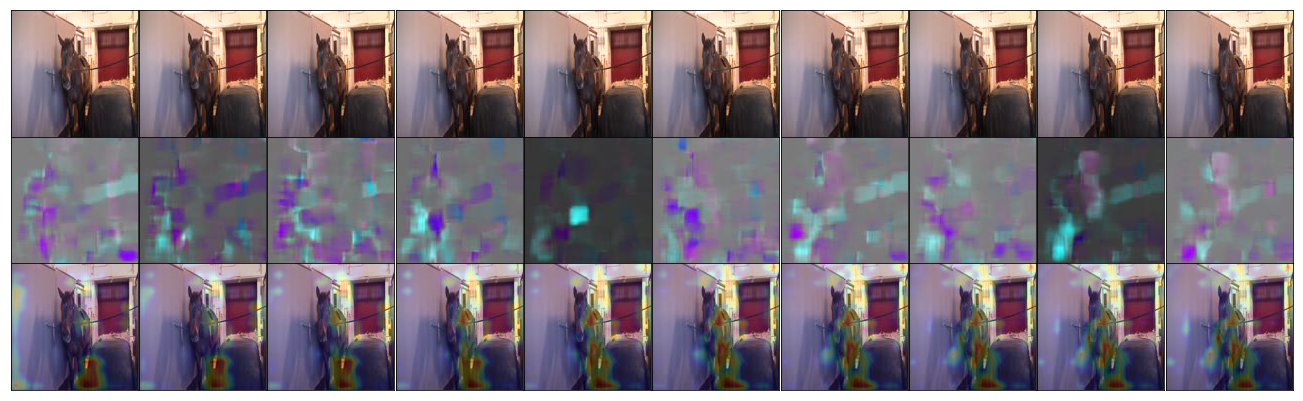

In [20]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);

Chose subject  3
Start index in subject dataframe:  12089
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_3a/frame_001146.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_3a/frame_001147.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_3a/frame_001148.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_3a/frame_001149.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_3a/frame_001150.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_3a/frame_001151.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_3a/frame_001152.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_3a/frame_001153.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_3a/frame_001154.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_3a/frame_001155.jpg     1
[[[0.6333203  0.32633826]
  [0.57476485 0.4360394 ]
  [0.43068525 0.652495  ]
  [0.22510405 0.914756  ]
  [0.0949713  0.9765122 ]
  [0.04527225 0.9911547 ]
  [0.04292624 0.9943304 ]
  [0.05055107 0.996111  ]
  [0.04898907 0.99681854]
  [0.06634911 0.99678683]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


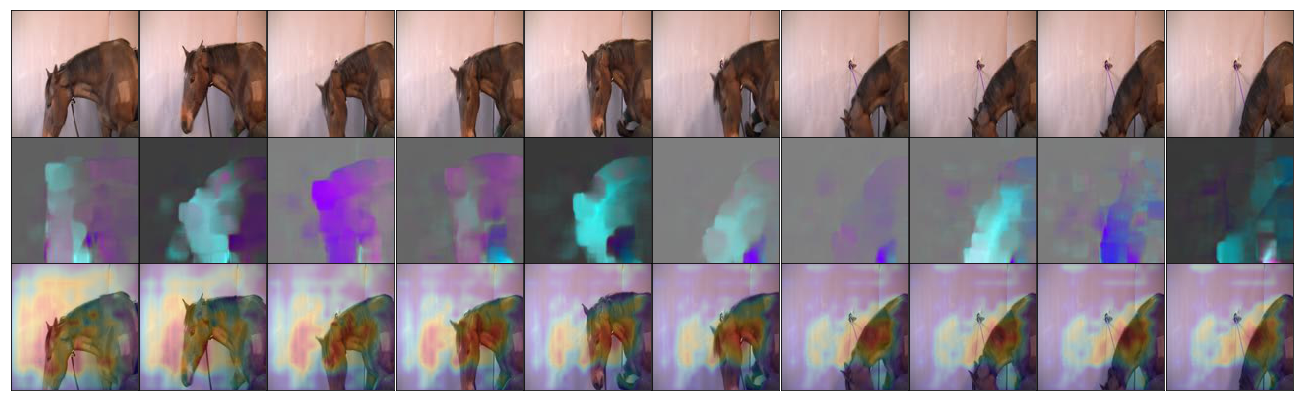

In [21]:
batch_img, batch_flow, batch_label = utils.data_for_one_random_sequence_two_stream(args, subject_dfs, computer='local', subject=3)
run_on_one_sequence(sess, clstm_model, batch_img, batch_flow, two_stream=True);